# Load data and fragment + index

In [ ]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
from tqdm import tqdm
import base64
class MMPGenerator:
    def __init__(self, df_input, output_csv, mmpa_dir='./mmpa',
                 symmetric=True, max_heavy=14, max_ratio=0.7, verbose=True):
        self.df_original = df_input.copy()
        self.output_csv = output_csv
        self.mmpa_dir = mmpa_dir
        self.symmetric = symmetric
        self.max_heavy = max_heavy
        self.max_ratio = max_ratio
        self.verbose = verbose

    def _get_inchikey(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.inchi.MolToInchiKey(mol)
        return self.encode_string(smiles)

    def encode_string(self, s):
        return base64.urlsafe_b64encode(s.encode()).decode()

    def decode_string(self, b64):
        return base64.urlsafe_b64decode(b64.encode()).decode()

    def run(self):
        self.df_original['ID'] = [self._get_inchikey(smi) for smi in self.df_original['SMILES']]
        y_map = self.df_original.set_index('ID')['Y'].to_dict()

        with tempfile.TemporaryDirectory() as tmp:
            smi_path = os.path.join(tmp, 'input.smi')
            frag_path = os.path.join(tmp, 'fragmented.txt')
            mmps_path = os.path.join(tmp, 'mmps.csv')
            smirks_path = os.path.join(tmp, 'smirks.txt')
            cansmirks_path = os.path.join(tmp, 'cansmirks.txt')

            self.df_original[['SMILES', 'ID']].to_csv(smi_path, index=False, sep=' ', header=False)

            with open(frag_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/rfrag.py'], stdin=open(smi_path), stdout=out)

            cmd = ['python', f'{self.mmpa_dir}/indexing.py']
            if self.symmetric:
                cmd.append('-s')
            if self.max_heavy:
                cmd.extend(['-m', str(self.max_heavy)])
            if self.max_ratio:
                cmd.extend(['-r', str(self.max_ratio)])

            with open(mmps_path, 'w') as out:
                subprocess.run(cmd, stdin=open(frag_path), stdout=out)

            with open(mmps_path) as f:
                lines = [line.strip() for line in f if line.strip()]


            splits = [line.split(',') for line in lines]
            max_len = max(len(s) for s in splits)

            df = pd.DataFrame(splits, columns=['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE'])


            df['L_Y'] = df['L_ID'].map(y_map)
            df['R_Y'] = df['R_ID'].map(y_map)
            df['Delta_Y'] = df['R_Y'] - df['L_Y']

            df = df[df['SMIRKS'].apply(lambda x: isinstance(x, str) and '>>' in x)]

            df['__row'] = range(len(df))
            df[['SMIRKS', '__row']].to_csv(smirks_path, index=False, sep=' ', header=False)

            with open(cansmirks_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/cansmirk.py'], stdin=open(smirks_path), stdout=out)


            canon_df = pd.read_csv(cansmirks_path, sep=' ', names=['Canonical_SMIRKS', 'index'])


            df = df.merge(canon_df, left_on='__row', right_on='index').drop(columns=['__row', 'index'])

            df[['L_sub', 'R_sub']] = df['Canonical_SMIRKS'].str.split('>>', expand=True)


            df['L_sub_ID'] = [self.encode_string(k) for k in df['L_sub'].tolist()]
            df['R_sub_ID'] = [self.encode_string(k) for k in df['R_sub'].tolist()]
            df['SMIRKS_ID'] = [self.encode_string(k) for k in df['Canonical_SMIRKS'].tolist()]
            df['CORE_ID'] = [self.encode_string(k) for k in df['CORE'].tolist()]
            df = df.drop_duplicates()


            df[['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE', 'L_Y', 'R_Y', 'Delta_Y', 'L_sub', 'R_sub', 'L_sub_ID', 'R_sub_ID', 'SMIRKS_ID', 'CORE_ID']].to_csv(
                self.output_csv, index=False
            )




import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time

class MMPAugmentorFixed:
    def __init__(self, df, min_common=4, pearson_thresh=0.3, crmsd_thresh=0.4):
        self.df = df.copy()
        self.min_common = min_common
        self.pearson_thresh = pearson_thresh
        self.crmsd_thresh = crmsd_thresh
        self.series = {}
        self.pair_scores = []
        self.filtered_pairs = []
        self.augmented_data = []

    def _extract_series(self):
        start = time.time()
        self.series = {
            core: group for core, group in self.df.groupby("CORE")
        }

    def _compute_pairwise_scores(self):
        start = time.time()
        self.pair_scores = []
        series_items = list(self.series.items())
        total_combinations = len(series_items) * (len(series_items) - 1) // 2
        for (core1, df1), (core2, df2) in   combinations(series_items, 2):
            subs1 = set(df1["L_sub"])
            subs2 = set(df2["L_sub"])
            common = subs1 & subs2
            if len(common) < self.min_common:
                continue

            merged = pd.merge(
                df1, df2,
                left_on=["L_sub", "R_sub"],
                right_on=["L_sub", "R_sub"],
                suffixes=('_1', '_2')
            )
            if len(merged) < self.min_common:
                continue

            y1 = merged['Delta_Y_1'].values
            y2 = merged['Delta_Y_2'].values
            crmsd = np.sqrt(np.mean((y1 - y2) ** 2))
            try:
                corr = pearsonr(y1, y2)[0]
            except:
                corr = np.nan

            self.pair_scores.append((core1, core2, crmsd, corr, len(merged)))

    def _filter_pairs(self):
        start = time.time()
        self.filtered_pairs = [
            (s1, s2) for s1, s2, rmsd, corr, n in self.pair_scores
            if rmsd <= self.crmsd_thresh and (not np.isnan(corr) and corr >= self.pearson_thresh)
        ]

    def _augment(self):
        start = time.time()
        augmented_entries = []

        for s1, s2 in self.filtered_pairs:
            df1 = self.series[s1]
            df2 = self.series[s2]

            tf1 = df1[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")
            tf2 = df2[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")

            df1_dict = defaultdict(list)
            for _, row in df1.iterrows():
                df1_dict[row["L_sub"]].append(row.to_dict())

            df2_dict = defaultdict(list)
            for _, row in df2.iterrows():
                df2_dict[row["L_sub"]].append(row.to_dict())

            for entry in tf1:
                l_sub = entry["L_sub"]
                for base in df2_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s1,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "Annotation": "Predicted",
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s1.encode()).decode()
                    })

            for entry in tf2:
                l_sub = entry["L_sub"]
                for base in df1_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s2,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "Annotation": "Predicted",
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s2.encode()).decode()
                    })

        self.augmented_data = pd.DataFrame(augmented_entries)


    def run(self):
        self._extract_series()
        self._compute_pairwise_scores()
        self._filter_pairs()
        self._augment()

        original = self.df.copy()
        original["Annotation"] = "Experimental"
        return pd.concat([original, self.augmented_data], ignore_index=True)
    
    def get_pair_scores_df(self):
        """
        Return a DataFrame of scaffold pair scores (cRMSD, Pearson, common MMP count)
        """
        return pd.DataFrame(
            self.pair_scores,
            columns=["Scaffold_1", "Scaffold_2", "cRMSD", "Pearson", "N_common"]
        )

    def get_augmented_only(self):
        """
        Return only the augmented (predicted) entries.
        """
        return self.augmented_data.copy()
    

def analyze_scaffold_pair_scores(df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    summary = {
        "Total Pairs": len(df),
        "Mean cRMSD": df["cRMSD"].mean(),
        "Median cRMSD": df["cRMSD"].median(),
        "Std cRMSD": df["cRMSD"].std(),
        "Mean Pearson": df["Pearson"].mean(),
        "Median Pearson": df["Pearson"].median(),
        "Std Pearson": df["Pearson"].std(),
        "Mean N_common": df["N_common"].mean(),
        "Median N_common": df["N_common"].median()
    }

    high_corr = df["Pearson"] > 0.7
    low_crmsd = df["cRMSD"] < 0.5
    enough_common = df["N_common"] >= 5
    strong_pairs = df[high_corr & low_crmsd & enough_common]

    summary.update({
        "High Pearson (>0.7)": high_corr.sum(),
        "Low cRMSD (<0.5)": low_crmsd.sum(),
        "N_common ≥ 5": enough_common.sum(),
        "Strong Pairs (all 3)": len(strong_pairs)
    })

 



    top_corr = df.sort_values("Pearson", ascending=False).head(5)
    top_low_crmsd = df.sort_values("cRMSD").head(5)
    top_common = df.sort_values("N_common", ascending=False).head(5)

    return {
        "summary": summary,
        "top_corr": top_corr,
        "top_low_crmsd": top_low_crmsd,
        "top_common": top_common,
        "strong_pairs": strong_pairs
    }


def prepare_and_plot_prediction_vs_experiment_complete_with_output(clean_df, std_threshold=0.5):
    import seaborn as sns
    import matplotlib.pyplot as plt

    clean_df_exp = clean_df[clean_df["Annotation"] != "Predicted"].copy()
    clean_df_pred = clean_df[clean_df["Annotation"] == "Predicted"].copy()
    # Normalize column names
    clean_df_exp = clean_df_exp.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})
    clean_df_pred = clean_df_pred.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})

    # Compute median and std per SMILES in predicted
    grouped_pred = clean_df_pred.groupby("SMILES")["Y"].agg(["median", "std"]).reset_index()
    grouped_pred.columns = ["SMILES", "Y", "Predicted_Std_Y"]
    grouped_pred["Annotation"] = "Predicted"

    grouped_pred = grouped_pred[grouped_pred["Predicted_Std_Y"]<= std_threshold]

    # Final prediction rows
    exp_out = clean_df_exp[["SMILES", "Y"]].copy()
    exp_out["Predicted_Std_Y"] = None
    exp_out["Annotation"] = "Experimental"

    output_df = pd.concat([exp_out.drop_duplicates("SMILES") , grouped_pred.drop_duplicates("SMILES") ], ignore_index=True)
    output_df = output_df[~((output_df['Annotation'] == 'Predicted') & (output_df['SMILES'].isin(output_df.loc[output_df['Annotation'] == 'Experimental', 'SMILES'])))]

    # Merge only for shared SMILES
    merged_df = pd.merge(clean_df_exp, grouped_pred, on="SMILES", how="inner")

    # === BARPLOT OF COUNTS ===
    exp_unique = set(clean_df_exp["SMILES"])
    pred_unique = set(clean_df_pred["SMILES"])
    shared = exp_unique & pred_unique
    only_pred = pred_unique - exp_unique

    counts = {
        "Experimental Only": len(exp_unique - pred_unique),
        "Predicted Only": len(only_pred),
        "Shared": len(shared),
        "Experimental Total": len(exp_unique),
        "Predicted Total": len(pred_unique)
    }

    return merged_df, output_df


import time
from sklearn.metrics import mean_squared_error, r2_score
def full_rf_validation_pipeline_profiled():
    from rdkit import Chem
    from rdkit.Chem import DataStructs
    from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import KFold
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from joblib import Parallel, delayed

    def compute_single_fp(smi, radius=4, n_bits=4096):
        from rdkit import Chem
        from rdkit.Chem import DataStructs
        from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
            fp = generator.GetFingerprint(mol)
            arr = np.zeros((1,), dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
            return arr
        return np.full(n_bits, 0)

    def compute_all_fingerprints_parallel(data, radius=4, n_bits=4096, n_jobs=-1):
        t0 = time.time()
        fps = Parallel(n_jobs=n_jobs)(
            delayed(compute_single_fp)(smi) for smi in data["SMILES"]
        )
        return np.array(fps)



    def evaluate_rf_on_augmentation(data, n_splits=5, n_repeats=3):
        data = data.dropna(subset=["SMILES", "Y"]).reset_index(drop=True)
        all_fps = compute_all_fingerprints_parallel(data)
        results = []
        metrics = []

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold = 0
        exp_indices = data[data.Annotation == "Experimental"].index.to_numpy()

        for train_idx, test_idx in kf.split(exp_indices):
            fold += 1
            train_exp_idx = exp_indices[train_idx]
            test_exp_idx = exp_indices[test_idx]
            pred_idx = data[data.Annotation == "Predicted"].index.to_numpy()
            train_aug_idx = np.concatenate([train_exp_idx, pred_idx])

            X_train_exp = all_fps[train_exp_idx]
            y_train_exp = data.loc[train_exp_idx, "Y"].values
            X_train_aug = all_fps[train_aug_idx]
            y_train_aug = data.loc[train_aug_idx, "Y"].values
            X_test = all_fps[test_exp_idx]
            y_test = data.loc[test_exp_idx, "Y"].values
            smiles_test = data.loc[test_exp_idx, "SMILES"].values


            preds_aug, preds_noaug = [], []

            for rep in range(n_repeats):
                t1 = time.time()
                state_rd = np.random.randint(10000)
                model_aug = RandomForestRegressor(n_jobs=-1, random_state=state_rd, n_estimators=300)
                model_aug.fit(X_train_aug, y_train_aug)

                t2 = time.time()
                model_noaug = RandomForestRegressor(n_jobs=-1, random_state=state_rd, n_estimators=300)
                model_noaug.fit(X_train_exp, y_train_exp)

                preds_aug.append(model_aug.predict(X_test))
                preds_noaug.append(model_noaug.predict(X_test))

            y_pred_aug = np.median(np.array(preds_aug), axis=0)
            y_pred_noaug = np.median(np.array(preds_noaug), axis=0)

            rmse_aug = mean_squared_error(y_test, y_pred_aug, squared=False)
            r2_aug = r2_score(y_test, y_pred_aug)
            rmse_noaug = mean_squared_error(y_test, y_pred_noaug, squared=False)
            r2_noaug = r2_score(y_test, y_pred_noaug)

            metrics.append({
                "Fold": fold,
                "RMSE_Aug": rmse_aug,
                "R2_Aug": r2_aug,
                "RMSE_NoAug": rmse_noaug,
                "R2_NoAug": r2_noaug
            })

            for i, smi in enumerate(smiles_test):
                true_y = y_test[i]
                aug_preds = [p[i] for p in preds_aug]
                noaug_preds = [p[i] for p in preds_noaug]

                results.append({
                    "SMILES": smi,
                    "True_Y": true_y,
                    "Median_Pred_Aug": np.median(aug_preds),
                    "Std_Pred_Aug": np.std(aug_preds),
                    "Med_AE_Aug": np.median(np.abs(np.array(aug_preds) - true_y)),
                    "Median_Pred_NoAug": np.median(noaug_preds),
                    "Std_Pred_NoAug": np.std(noaug_preds),
                    "Med_AE_NoAug": np.median(np.abs(np.array(noaug_preds) - true_y)),
                    "Fold": fold
                })

        metrics_df = pd.DataFrame(metrics)

        return pd.DataFrame(results), metrics_df
    return evaluate_rf_on_augmentation


def fast_apply_transformation(transformation, smiles, rxn_cache):
    if pd.isna(transformation) or pd.isna(smiles):
        return None
    if transformation not in rxn_cache:
        rxn = AllChem.ReactionFromSmarts(transformation)
        rxn_cache[transformation] = rxn
    else:
        rxn = rxn_cache[transformation]
    if rxn is None:
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        products = rxn.RunReactants((mol,))
    except Exception:
        return None
    if products and products[0]:
        return Chem.MolToSmiles(products[0][0])
    return None

def update_predicted_rows(df):
    mask = df["Annotation"] == "Predicted"
    indices = df[mask].index

    rxn_cache = {}
    for idx in indices:
        row = df.loc[idx]
        l_smiles = row["L_SMILES"]
        smirks = row["SMIRKS"]
        r_smiles = fast_apply_transformation(smirks, l_smiles, rxn_cache)
        if r_smiles:
            mol = Chem.MolFromSmiles(r_smiles)
            r_id = Chem.InchiToInchiKey(Chem.MolToInchi(mol)) if mol else None
        else:
            r_id = None
        df.at[idx, "R_SMILES"] = r_smiles
        df.at[idx, "R_ID"] = r_id

    return df

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def plot_cv_metrics(metrics_df):
    plt.figure(figsize=(12, 5))

    # Boxplot RMSE
    plt.subplot(1, 2, 1)
    rmse_melted = metrics_df.melt(id_vars="Fold", value_vars=["RMSE_Aug", "RMSE_NoAug"],
                                  var_name="Condition", value_name="RMSE")
    sns.boxplot(data=rmse_melted, x="Condition", y="RMSE", palette="Set2")
    plt.title("RMSE per Fold")
    plt.grid(True)

    # Boxplot R2
    plt.subplot(1, 2, 2)
    r2_melted = metrics_df.melt(id_vars="Fold", value_vars=["R2_Aug", "R2_NoAug"],
                                var_name="Condition", value_name="R²")
    sns.boxplot(data=r2_melted, x="Condition", y="R²", palette="Set2")
    plt.title("R² per Fold")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_top_models_summary(results_list, top_n=10):
    df_pareto = pd.DataFrame(results_list)
    df_top = df_pareto.sort_values(by=['median_r2', 'median_size_increase'], ascending=[False, False]).head(top_n)

    print("=== Top Pareto Models ===")
    print(df_top[['trial', 'median_r2', 'median_size_increase', 'params']])

    # Collect and combine all metric DataFrames
    metric_records = []
    for _, row in df_top.iterrows():
        for detail in row['details']:
            df = detail['metrics_df'].copy()
            df['Target'] = detail['col']
            df['Trial'] = row['trial']
            metric_records.append(df)

    combined_df = pd.concat(metric_records, ignore_index=True)

    # Aggregate per target
    agg_df = combined_df.groupby('Target').agg({
        'R2_Aug': ['mean', 'std'],
        'R2_NoAug': ['mean', 'std'],
        'RMSE_Aug': ['mean'],
        'RMSE_NoAug': ['mean']
    })
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df = agg_df.reset_index()

    # Calculate improvement
    agg_df['Delta_R2'] = agg_df['R2_Aug_mean'] - agg_df['R2_NoAug_mean']
    agg_df['Delta_RMSE'] = agg_df['RMSE_NoAug_mean'] - agg_df['RMSE_Aug_mean']

    print("\n=== Per-Target Summary ===")
    print(agg_df[['Target', 'R2_NoAug_mean', 'R2_Aug_mean', 'Delta_R2', 'RMSE_NoAug_mean', 'RMSE_Aug_mean', 'Delta_RMSE']])

    # Plot: R2 Augmented vs Non-Augmented per target
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(agg_df))
    plt.bar(index, agg_df['R2_NoAug_mean'], bar_width, label='Non-Augmented')
    plt.bar([i + bar_width for i in index], agg_df['R2_Aug_mean'], bar_width, label='Augmented')
    plt.xticks([i + bar_width / 2 for i in index], agg_df['Target'], rotation=90, ha='right')
    plt.ylabel("Mean R2")
    plt.title("Mean R2 per Target (Augmented vs Non-Augmented)")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot: Delta R2 per Target
    plt.figure(figsize=(12, 5))
    sns.barplot(data=agg_df, x='Target', y='Delta_R2', palette='coolwarm')
    plt.axhline(0, linestyle='--', color='black')
    plt.ylabel("R2 Gain (Augmented - Non-Augmented)")
    plt.title("R2 Gain from Augmentation per Target")
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot: R2 progression per trial
    trial_r2 = df_top[['trial', 'median_r2']].sort_values('trial')
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trial_r2, x='trial', y='median_r2', marker='o')
    plt.title("Median R2 Progression Across Top Trials")
    plt.xlabel("Trial Number")
    plt.ylabel("Median Adjusted R2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_top_models_best(results_list, top_n=10):
    df_pareto = pd.DataFrame(results_list)
    df_top = df_pareto.sort_values(by=['median_r2', 'median_size_increase'], ascending=[False, False]).head(top_n)

    print("=== Top Pareto Models ===")
    print(df_top[['trial', 'median_r2', 'median_size_increase', 'params']])

    # Collect and combine all metric DataFrames
    metric_records = []
    for _, row in df_top.iterrows():
        for detail in row['details']:
            df = detail['metrics_df'].copy()
            df['Target'] = detail['col']
            df['Trial'] = row['trial']
            metric_records.append(df)

    combined_df = pd.concat(metric_records, ignore_index=True)

    # Aggregate per target: take max R2 and min RMSE
    agg_df = combined_df.groupby('Target').agg({
        'R2_Aug': 'max',
        'R2_NoAug': 'max',
        'RMSE_Aug': 'min',
        'RMSE_NoAug': 'min'
    }).reset_index()

    # Calculate improvement
    agg_df['Delta_R2'] = agg_df['R2_Aug'] - agg_df['R2_NoAug']
    agg_df['Delta_RMSE'] = agg_df['RMSE_NoAug'] - agg_df['RMSE_Aug']

    print("\n=== Per-Target Best Performance ===")
    print(agg_df[['Target', 'R2_NoAug', 'R2_Aug', 'Delta_R2', 'RMSE_NoAug', 'RMSE_Aug', 'Delta_RMSE']])

    # Plot: R2 Augmented vs Non-Augmented per target
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(agg_df))
    plt.bar(index, agg_df['R2_NoAug'], bar_width, label='Non-Augmented')
    plt.bar([i + bar_width for i in index], agg_df['R2_Aug'], bar_width, label='Augmented')
    plt.xticks([i + bar_width / 2 for i in index], agg_df['Target'], rotation=45, ha='right')
    plt.ylabel("Best R2")
    plt.title("Best R2 per Target (Augmented vs Non-Augmented)")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot: Delta R2 per Target
    plt.figure(figsize=(12, 5))
    sns.barplot(data=agg_df, x='Target', y='Delta_R2', palette='coolwarm')
    plt.axhline(0, linestyle='--', color='black')
    plt.ylabel("R2 Gain (Augmented - Non-Augmented)")
    plt.title("R2 Gain from Augmentation per Target (Best Fold)")
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot: R2 progression per trial
    trial_r2 = df_top[['trial', 'median_r2']].sort_values('trial')
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trial_r2, x='trial', y='median_r2', marker='o')
    plt.title("Median R2 Progression Across Top Trials")
    plt.xlabel("Trial Number")
    plt.ylabel("Median Adjusted R2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    from scipy.stats import ttest_rel
import numpy as np

def analyze_top_models_best_boxplot_with_stats(results_list, top_n=10):
    df_pareto = pd.DataFrame(results_list)
    df_top = df_pareto.sort_values(by=['median_r2', 'median_size_increase'], ascending=[False, False]).head(top_n)

    print("=== Top Pareto Models ===")
    print(df_top[['trial', 'median_r2', 'median_size_increase', 'params']])

    # Collect and combine all metric DataFrames
    metric_records = []
    for _, row in df_top.iterrows():
        for detail in row['details']:
            df = detail['metrics_df'].copy()
            df['Target'] = detail['col']
            df['Trial'] = row['trial']
            metric_records.append(df)

    combined_df = pd.concat(metric_records, ignore_index=True)

    # Melt for R2
    melted_r2 = combined_df.melt(id_vars=["Target", "Trial"], value_vars=["R2_Aug", "R2_NoAug"],
                                 var_name="Type", value_name="R2")
    melted_r2['Type'] = melted_r2['Type'].map({'R2_Aug': 'Augmented', 'R2_NoAug': 'Non-Augmented'})

    # Plot with statistical significance
    plt.figure(figsize=(8, 8))
    sns.boxplot(data=melted_r2, x='Target', y='R2', hue='Type')
    plt.title("R2 Distribution per Target (Augmented vs Non-Augmented)")
    plt.xticks(rotation=90, ha='right')
    plt.grid(True)

    # T-test and significance stars
    targets = combined_df['Target'].unique()
    for i, target in enumerate(targets):
        sub = combined_df[combined_df['Target'] == target]
        if len(sub) >= 2:
            tstat, pval = ttest_rel(sub['R2_Aug'], sub['R2_NoAug'])
            if pval < 0.0001:
                label = '***'
            elif pval < 0.001:
                label = '**'
            elif pval < 0.01:
                label = '*'
            elif pval < 0.05:
                label = '.'
            else:
                label = '-'
            max_val = max(sub['R2_Aug'].max(), sub['R2_NoAug'].max())
            plt.text(i, max_val + 0.0, label, ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Melt for RMSE
    melted_rmse = combined_df.melt(id_vars=["Target", "Trial"], value_vars=["RMSE_Aug", "RMSE_NoAug"],
                                   var_name="Type", value_name="RMSE")
    melted_rmse['Type'] = melted_rmse['Type'].map({'RMSE_Aug': 'Augmented', 'RMSE_NoAug': 'Non-Augmented'})

    plt.figure(figsize=(8, 8))
    sns.boxplot(data=melted_rmse, x='Target', y='RMSE', hue='Type')
    plt.title("RMSE Distribution per Target (Augmented vs Non-Augmented)")
    plt.xticks(rotation=90, ha='right')
    plt.grid(True)

    # T-test and significance stars for RMSE
    for i, target in enumerate(targets):
        sub = combined_df[combined_df['Target'] == target]
        if len(sub) >= 2:
            tstat, pval = ttest_rel(sub['RMSE_NoAug'], sub['RMSE_Aug'])  # lower RMSE is better
            if pval < 0.0001:
                label = '***'
            elif pval < 0.001:
                label = '**'
            elif pval < 0.01:
                label = '*'
            elif pval < 0.05:
                label = '.'
            else:
                label = '-'
            max_val = max(sub['RMSE_Aug'].max(), sub['RMSE_NoAug'].max())
            plt.text(i, max_val + 0.00, label, ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    # R2 progression
    trial_r2 = df_top[['trial', 'median_r2']].sort_values('trial')
    plt.figure(figsize=(8, 8))
    sns.lineplot(data=trial_r2, x='trial', y='median_r2', marker='o')
    plt.title("Median R2 Progression Across Top Trials")
    plt.xlabel("Trial Number")
    plt.ylabel("Median Adjusted R2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


import matplotlib.pyplot as plt
import seaborn as sns

def plot_cv_metrics(metrics_df):
    plt.figure(figsize=(12, 5))

    # Boxplot RMSE
    plt.subplot(1, 2, 1)
    rmse_melted = metrics_df.melt(id_vars="Fold", value_vars=["RMSE_Aug", "RMSE_NoAug"],
                                  var_name="Condition", value_name="RMSE")
    sns.boxplot(data=rmse_melted, x="Condition", y="RMSE", palette="Set2")
    plt.title("RMSE per Fold")
    plt.grid(True)

    # Boxplot R2
    plt.subplot(1, 2, 2)
    r2_melted = metrics_df.melt(id_vars="Fold", value_vars=["R2_Aug", "R2_NoAug"],
                                var_name="Condition", value_name="R²")
    sns.boxplot(data=r2_melted, x="Condition", y="R²", palette="Set2")
    plt.title("R² per Fold")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Data and endpoints

In [3]:
df_full = pd.read_parquet('./data/cleaned_dataset_toy___key_results.parquet')
col = "BindingDB___pIC50_PDE10_RAT_Biochemical.csv"
df = df_full[["SMILES", col]].dropna()
df.columns = ["SMILES", "Y"]

# Run

In [5]:
max_heavy = 15
max_ratio = 0.3
min_common = 4
pearson_thresh = 0.3
crmsd_thresh = 0.6
std_threshold = 0.6

MMPGenerator(df, output_csv=f'out_{col}.csv', symmetric=True, max_heavy=max_heavy, max_ratio=max_ratio, verbose=True).run()
augmentor = MMPAugmentorFixed(pd.read_csv(f'out_{col}.csv', on_bad_lines="skip") , min_common=min_common, pearson_thresh=pearson_thresh, crmsd_thresh=crmsd_thresh)
final_df3 = augmentor.run()
final_df3 = final_df3.drop_duplicates()
rxn_cache = {}
imputed_df = update_predicted_rows(final_df3)
l_df = imputed_df[["L_SMILES", "L_Y", "Annotation"]]
r_df = imputed_df[["R_SMILES", "R_Y", "Annotation"]]
l_df.columns = ["SMILES", "Y", "Annotation"]
r_df.columns = ["SMILES", "Y", "Annotation"]
clean_df = pd.concat([l_df, r_df])
clean_df_exp = clean_df[clean_df["Annotation"]!="Predicted"]
clean_df_pred = clean_df[clean_df["Annotation"]=="Predicted"]
clean_df_exp = clean_df_exp.drop_duplicates()
clean_df_pred = clean_df_pred.drop_duplicates()
merged_df, output_df = prepare_and_plot_prediction_vs_experiment_complete_with_output(clean_df, std_threshold=std_threshold)
evaluate_fn = full_rf_validation_pipeline_profiled()
results_df, metrics_df = evaluate_fn(output_df)


/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_1422/2051510654.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] WARNING: Omitted undefined stereo

[21:51:55] W

In [16]:
output_df.to_csv(f'augmented_{col}.csv', index=False)
metrics_df.to_csv(f'augmented_{col}_metrics.csv', index=False)

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_1422/705906550.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rmse_melted, x="Condition", y="RMSE", palette="Set2")
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_1422/705906550.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=r2_melted, x="Condition", y="R²", palette="Set2")


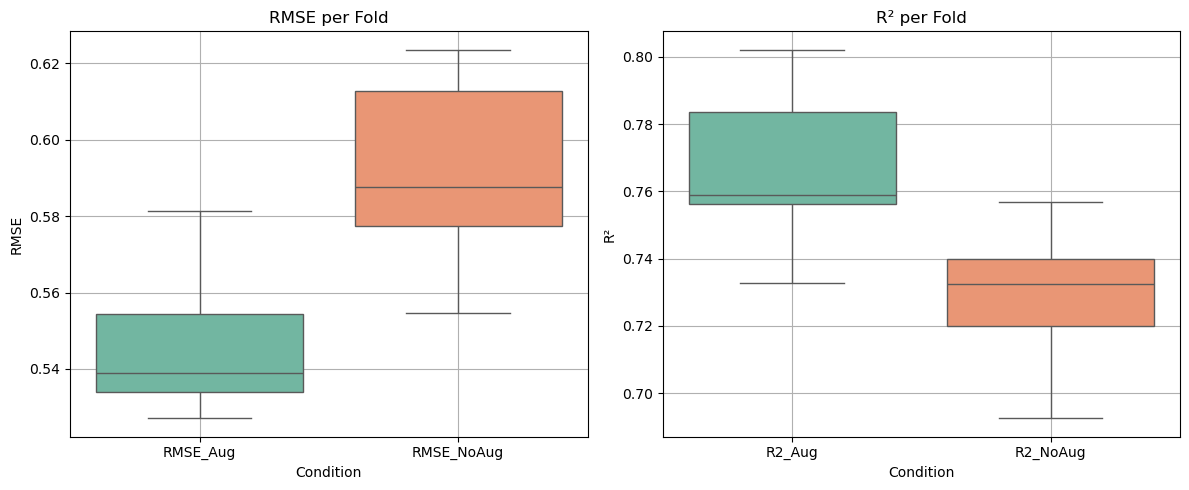

In [13]:
plot_cv_metrics(metrics_df)

/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


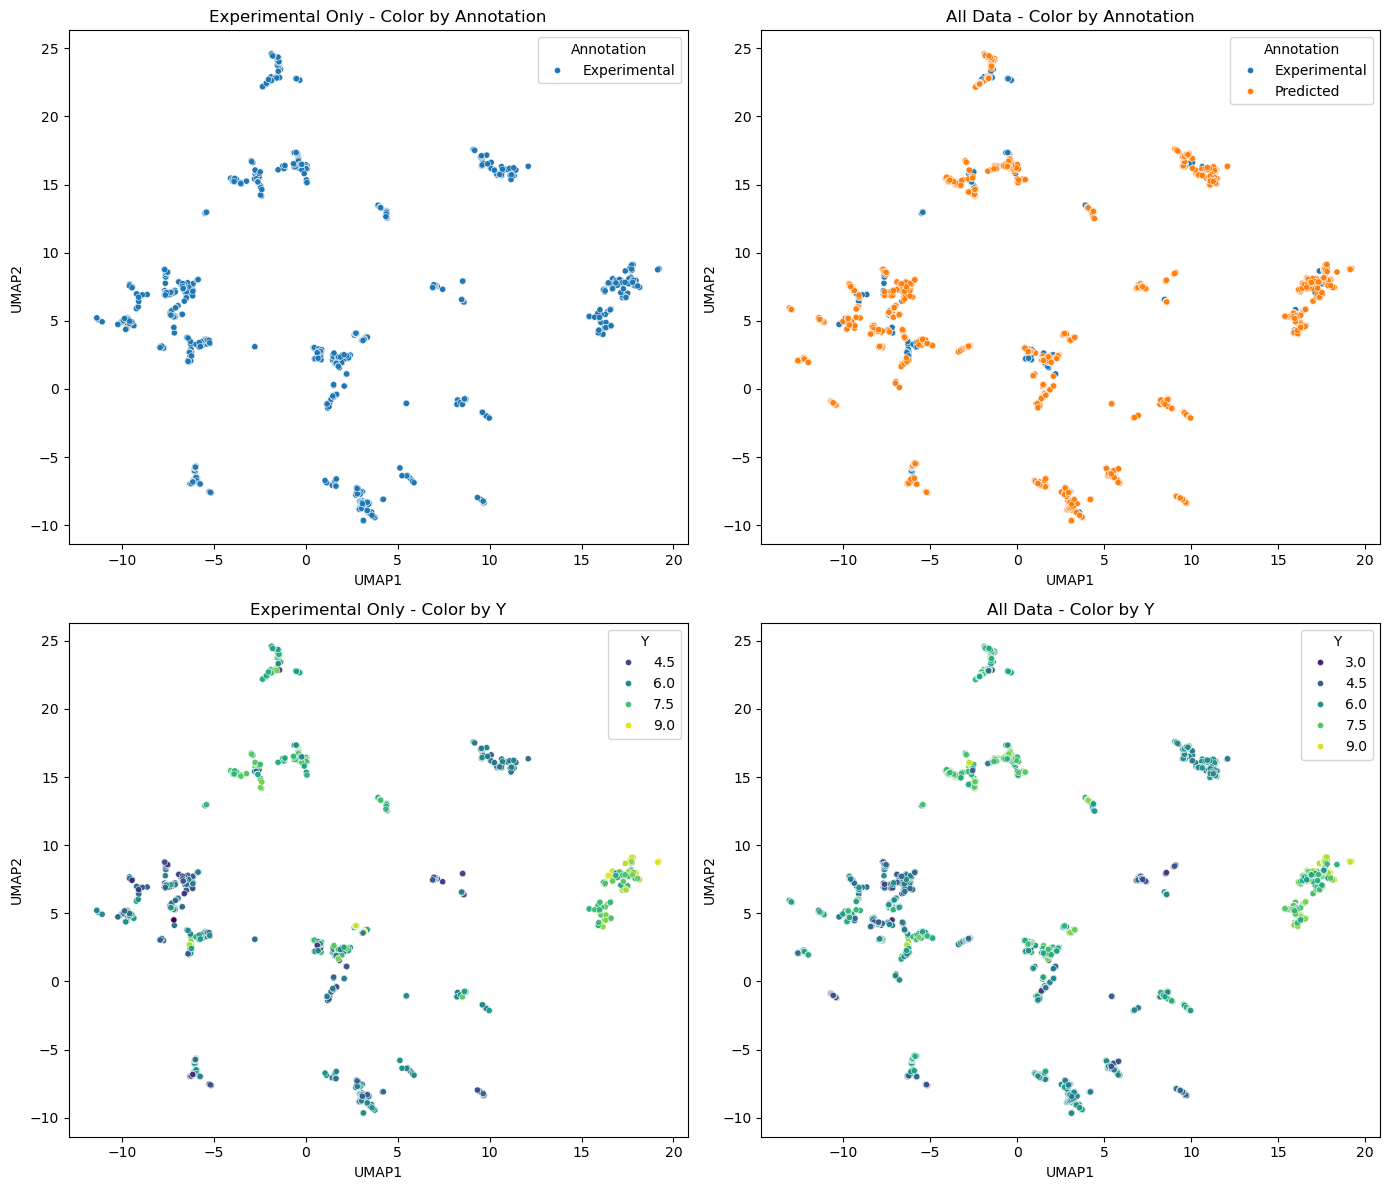

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import umap
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# Compute single ECFP
def compute_single_fp_safe(smi, radius=4, n_bits=4096):
    from rdkit import Chem
    from rdkit.Chem import DataStructs
    from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return np.full(n_bits, 0)

def compute_all_fingerprints_parallel(data, radius=4, n_bits=4096, n_jobs=1):
    # use n_jobs=1 if parallel still causes issues
    fps = Parallel(n_jobs=n_jobs)(
        delayed(compute_single_fp_safe)(smi) for smi in data["SMILES"]
    )
    return np.array(fps)
# Load your data
output_df = pd.read_csv(f'augmented_{col}.csv')
metrics_df = pd.read_csv(f'augmented_{col}_metrics.csv')

# Compute fingerprints
fps = compute_all_fingerprints_parallel(output_df)

# Run UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard')
embedding = reducer.fit_transform(fps)

# Merge UMAP with original data
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_plot = pd.concat([output_df, df_umap], axis=1)


In [21]:
df_plot

,SMILES,Y,Predicted_Std_Y,Annotation,UMAP1,UMAP2
0,C[n]1[n]c(C(C)C)c2CN(CCc12)c1[n]c[n][n]2c1c([n...,8.254925,NaN,Experimental,18.134768,7.459054
1,C[n]1[n]cc2C(C)CN(Cc12)c1[n]c[n][n]2c1c([n]c2C...,7.349692,NaN,Experimental,17.510458,7.015501
2,Cc1[n]c(C2COCC2)c2c([n]c[n][n]12)N1Cc2c(CC1)c[...,8.100727,NaN,Experimental,17.222828,6.700272
3,C[n]1c(=O)c2CN(CCc2[n]c1C)c1[n]c[n][n]2c1c([n]...,8.315155,NaN,Experimental,19.151375,8.766586
4,CCc1[n]c(C)[n]c2CCN(Cc21)c1[n]c[n][n]2c1c([n]c...,8.431798,NaN,Experimental,17.642347,8.718625
...,...,...,...,...,...,...
3656,c1cncc(C2CCN(c3nccnc3OC3CN(c4ccc5ccccc5n4)C3)C...,6.754745,0.245112,Predicted,-4.866955,3.183160
3657,c1cncc(CCNc2nccnc2OC2CCN(c3ccc4ccccc4n3)CC2)c1,5.521390,0.383672,Predicted,-8.424392,4.016828
3658,c1cncc(CNc2nccnc2OC2CCN(c3ccc4ccccc4n3)CC2)c1,4.696870,0.370662,Predicted,-8.415612,4.026563
3659,c1csc(-c2nccnc2OC2CCN(c3ccc4ccccc4n3)CC2)c1,6.897283,0.330211,Predicted,-11.351621,5.106954


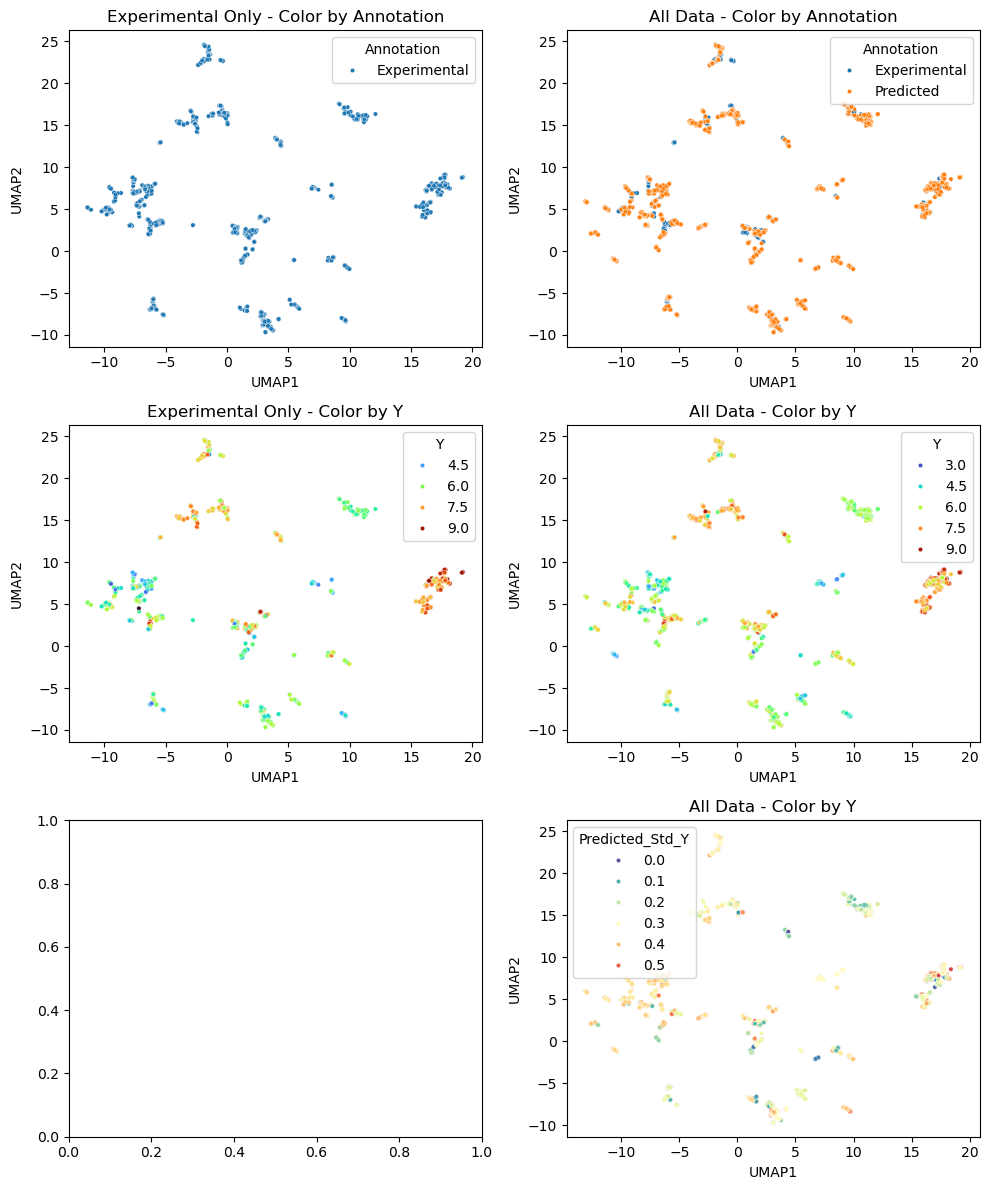

In [27]:

# Plot layout: 2x2 grid
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Top-left: Experimental + Annotation
exp_only = df_plot[df_plot["Annotation"] == "Experimental"]
sns.scatterplot(data=exp_only, x="UMAP1", y="UMAP2", hue="Annotation", ax=axes[0, 0], s=10)
axes[0, 0].set_title("Experimental Only - Color by Annotation")

# Bottom-left: Experimental + Y
sns.scatterplot(data=exp_only, x="UMAP1", y="UMAP2", hue="Y", palette="turbo", ax=axes[1, 0], s=10)
axes[1, 0].set_title("Experimental Only - Color by Y")

# Top-right: All + Annotation
sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2", hue="Annotation", ax=axes[0, 1], s=10)
axes[0, 1].set_title("All Data - Color by Annotation")

# Bottom-right: All + Y
sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2", hue="Y", palette="turbo", ax=axes[1, 1], s=10)
axes[1, 1].set_title("All Data - Color by Y")

# Bottom-right: All + Y
sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2", hue="Predicted_Std_Y", palette="Spectral_r", ax=axes[2, 1], s=10)
axes[2, 1].set_title("All Data - Color by Y")


plt.tight_layout()
plt.show()